In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import pickle as pkl
from lib.utils import *
from copy import deepcopy as dcp
from os import walk
import shutil
from lib.Wilson_Cowan.parameters_info import parameter_names, parameters_lower_bound,parameters_range_bounds
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'

In [2]:
cma_p = '../Data/WC/from_mid/cmaes/'
num_std_tested = [1]
init_files = []
runtime_CMA = []
all_std_errors = []
cma_fs = ['cmaes_25chk_120rd_all_0.05std_25repeats']
for iii, cma_f in enumerate(cma_fs):
    cmaes_log = get_log(cma_p,cma_f)
    for ii in range(num_std_tested[iii]):
        cmaes_errors = []
        run_time = []
        for j in range(ii,20*num_std_tested[iii],num_std_tested[iii]):
            errors = -cmaes_log[j]['fit_history']['error']
            run_time.append(cmaes_log[j]['overall_runtime'])
            cmaes_errors.append(errors)
        cmaes_errors = torch.cat(cmaes_errors, dim = 0).mean(-1)
        all_std_errors.append(cmaes_errors)
        runtime_CMA.append(torch.cat(run_time, dim = 0).mean(-1).numpy())
print(all_std_errors[0].shape)

torch.Size([20, 25, 121])


In [3]:
global_search_path_PSO = '../Data/WC/from_mid/PSO/'
PSO_paths = [
    'noinit-20targets_blw0.15_chunk25_120rds_PSO',
]
target_indices = [i for i in range(0,20)]
search_logs = [get_log(global_search_path_PSO, PSO_paths[i]) for i in range(len(PSO_paths))]
runtime_PSO = [search_logs[i][0]['overall_runtime'].squeeze().numpy() for i in range(len(PSO_paths))]
errors = [-search_logs[i][0]['fit_history']['error'][target_indices].mean(-1).numpy() for i in range(len(PSO_paths))]
best_PSO_mean_errors = [errors[i].mean(1, keepdims = True).mean(0, keepdims = True) for i in range(len(PSO_paths))]
best_PSO_std_errors = [[(best_PSO_mean_errors[i]-errors[i].std(1).mean(0)).squeeze(),
                      (best_PSO_mean_errors[i]+errors[i].std(1).mean(0)).squeeze()] for i in range(len(PSO_paths))]

In [4]:
final_files = [
    [
        ['noinit-20targets_blw0.14_chunk25_120rds_pure', 0],
		['noinit-20targets_blw0.11_chunk25_120rds_SA', 1],
    ]
]

target_indices = [i for i in range(20)]
results = []
runtime_RS = []
all_settings = []
global_search_path = '../Data/WC/from_mid/simple/'
random_search_paths = final_files
for ii in range(len(random_search_paths)):
    if random_search_paths[ii] is None:
        results.append(None)
        continue
    other_error = [None for _ in range(2)]
    best_other_error = [None for _ in range(2)]
    best_other_std_errors = [None for _ in range(2)]
    settings = [None for _ in range(2)]
    rt = [None for _ in range(2)]
    for j, path in enumerate(random_search_paths[ii]):
        file_er = get_log(global_search_path, path[0])
        try:
            err = -file_er[path[1]]['fit_history']['error'][target_indices][:,:,:121,:].mean(-1).numpy()
            rt[path[1]] = file_er[path[1]]['overall_runtime'].squeeze().numpy()
            settings[path[1]] = file_er[path[1]]['settings']
            other_error[path[1]] = err
            mean_err = err.mean(1, keepdims = True).mean(0, keepdims = True)
            best_other_error[path[1]] = mean_err
            best_other_std_errors[path[1]] = [(mean_err-err.std(1).mean(0)).squeeze(),
                              (mean_err+err.std(1).mean(0)).squeeze()]
        except:
            print(path)
            pass
    results.append([best_other_error, best_other_std_errors])
    runtime_RS.append(rt)
    all_settings.append(settings)

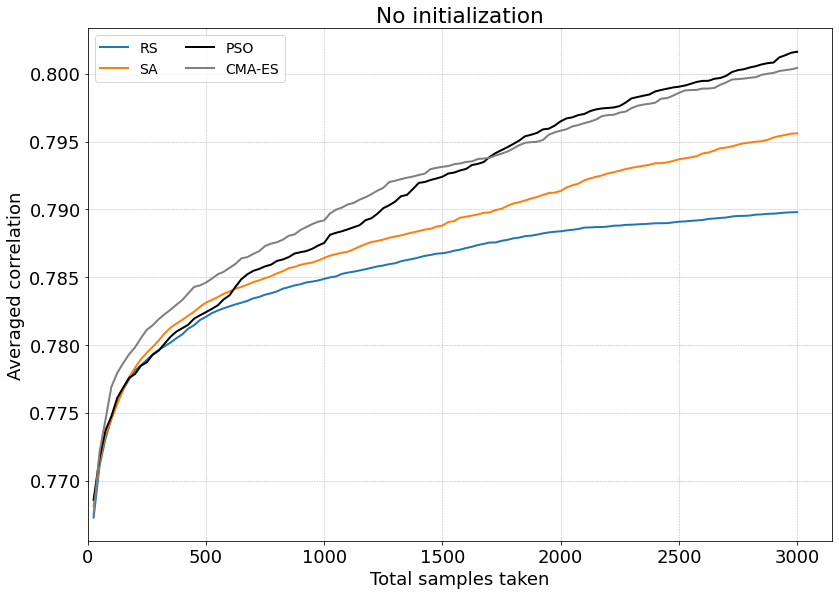

In [5]:
start = 0
titles = ['No initialization']
loss_fn = 'correlation'
initial_samp = [0]
num_rounds = 120
hide_pure = True
lim = num_rounds-start+1
labels = ['RS','SA','RS AE', 'RS PCA', 'SA AE', 'SA PCA']
cmae_stds = [0]
markers = [f'-r',f'--r','-C7',f'--C7',None,None]
ncol = 1
f = plt.figure(figsize=(12, 8* (len(results)//ncol +1)))
i = 0
ax = plt.subplot(len(results)//ncol +1,ncol,i+1)
cmae_std = cmae_stds[i]
cmae_num = cmae_stds[0]
if results[i] is not None:
    best_other_error = results[i][0]
    best_other_std_errors = results[i][1]
    color_num = 0
    for ii in range(0,2):
        lim = num_rounds-start+1
        samples = [initial_samp[i]+ 25*j for j in range(1,num_rounds+1)]
        plt.plot(samples,best_other_error[ii][:,:,1:lim].squeeze(), f'-C{color_num}', label = f"{labels[ii]}")
        color_num+=1
samples = [initial_samp[i]+ 25*j for j in range(1,num_rounds+1)]
plt.plot(samples,best_PSO_mean_errors[i][:,:,1:lim].squeeze(), '-k', label = f"PSO")
plt.plot([initial_samp[i]+25*j for j in range(1,num_rounds+1)], all_std_errors[cmae_std].mean(1).mean(0).numpy()[1:],'-C7', label = f'CMA-ES')
plt.xlim([initial_samp[i], None])
plt.title(f'{titles[i]}')
plt.ylabel(f"Averaged {loss_fn}")
plt.xlabel("Total samples taken")
plt.legend(ncol = 2, prop = {'size':14})
plt.grid(linestyle = "--", linewidth = 0.5)
plt.tight_layout()
plt.show()

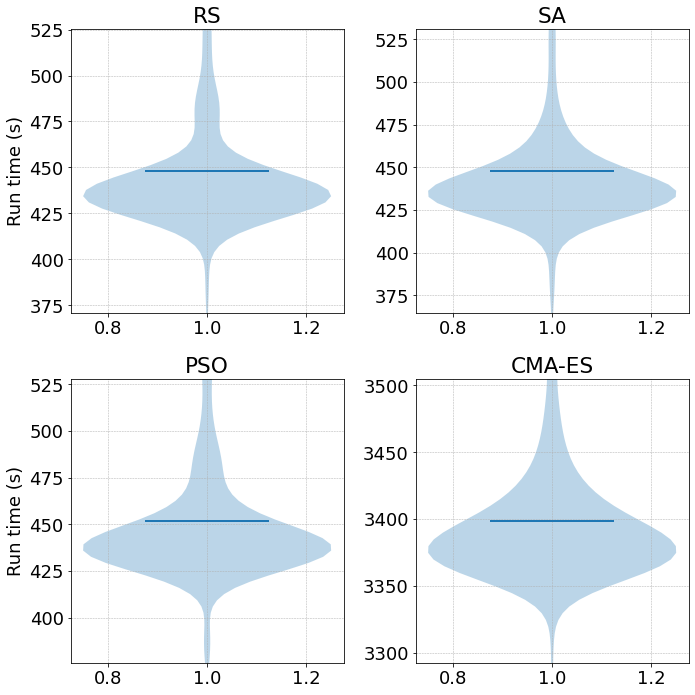

In [6]:
all_runtime_RS = [np.concatenate([runtime_RS[i][j].reshape((-1)) for i in range(1)]) for j in range(2)]
all_runtime_PSO = np.concatenate([ensure_numpy(runtime_PSO[i]).reshape((-1)) for i in range(1)])
all_runtime_CMA= np.concatenate([ensure_numpy(runtime_CMA[cmae_stds[i]]).reshape((-1)) for i in range(1)])
fig = plt.figure(figsize=(10,10))
for j in range(2):
    ax = plt.subplot(2,2,j+1)
    runt = ensure_numpy(all_runtime_RS[j]).reshape((-1))
    lower_b = runt.mean()-2*runt.std()
    upper_b = runt.mean()+2*runt.std()
    plt.violinplot(ensure_numpy(all_runtime_RS[j]).reshape((-1)),showmeans = True, showextrema = False)
    plt.ylim([max(lower_b,runt.min()), upper_b])
    plt.grid(linestyle = "--", linewidth = 0.5)
    if j == 0:
        plt.ylabel(f"Run time (s)")
    plt.title(f'{labels[j]}')
ax = plt.subplot(2,2,3)
lower_b = all_runtime_PSO.mean()-2*all_runtime_PSO.std()
upper_b = all_runtime_PSO.mean()+2*all_runtime_PSO.std()
plt.violinplot(all_runtime_PSO,showmeans = True, showextrema = False)
plt.ylim([max(lower_b,all_runtime_PSO.min()), upper_b])
plt.ylabel(f"Run time (s)")
plt.grid(linestyle = "--", linewidth = 0.5)
plt.title(f'PSO')
ax = plt.subplot(2,2,4)
lower_b = all_runtime_CMA.mean()-2*all_runtime_CMA.std()
upper_b = all_runtime_CMA.mean()+2*all_runtime_CMA.std()
plt.violinplot(all_runtime_CMA,showmeans = True, showextrema = False)
plt.ylim([max(lower_b,all_runtime_CMA.min()), min(upper_b,all_runtime_CMA.max())])
plt.grid(linestyle = "--", linewidth = 0.5)
plt.title(f'CMA-ES')
plt.tight_layout()
plt.show()